<a href="https://colab.research.google.com/github/fcMeade1/maiz_vistrosidad/blob/main/notebooks/analisis_maiz_fcm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Vitrosidad en Semillas de Maíz  
**Visión Computacional + Machine Learning**



In [63]:
# Clonación de Repositorio
import os

REPO_URL = "https://github.com/fcMeade1/maiz_vistrosidad.git"
REPO_DIR = "maiz_vistrosidad"

if not os.path.exists(REPO_DIR):
    !git clone {REPO_URL}

os.chdir(REPO_DIR)

print("Directorio actual:", os.getcwd())
print("Contenido del repositorio:", os.listdir())


Cloning into 'maiz_vistrosidad'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 142 (delta 13), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (142/142), 30.14 MiB | 30.17 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Directorio actual: /content/maiz_vistrosidad/maiz_vistrosidad/maiz_vistrosidad
Contenido del repositorio: ['notebooks', 'outputs', 'README.md', 'data', '.git', 'src']


Este notebook implementa un pipeline completo para analizar semillas de maíz mediante:
1. Exploración de datos (EDA)
2. Segmentación de área amarilla
3. Cálculo de la vitrosidad
4. Modelos predictivos (clasificación y regresión)
5. Reporte Final

## 1. Exploración de Datos (EDA)
Antes de procesar imágenes o construir modelos predictivos, es necesario entender qué
información contiene el dataset tabular, cómo están distribuidas sus variables y si existen
patrones relevantes entre productores, lotes o condiciones de secado.

En esta sección cargamos y exploramos el archivo `dataset_maiz_original.csv` que son metadatos asociados a cada imagen. El dataset contiene:
- id: nombre del archivo de imagen.
- batch: lote de origen.
- produccion kg: producción estimada asociada al lote.
- productor: finca o productor.
- humedad porcentaje
- temperatura secado c
- turno
- operador
- variedad

En este análisis veremos graficas que intentan describir la naturaleza de los datos

El dataset tiene la siguiente estructura:

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

df = pd.read_csv("data/dataset_maiz_original.csv")
df.head()

,id,batch,produccion_kg,productor,humedad_porcentaje,temperatura_secado_c,turno,operador,variedad
0,img_0001.png,B05,15.06,maizales_del_sur,14.73,51,tarde,OP07,hibrido
1,img_0002.png,B04,5.48,maizales_del_sur,14.48,57,tarde,OP05,amarillo
2,img_0003.png,B03,18.16,granja_el_sol,15.79,40,mañana,OP11,amarillo
3,img_0004.png,B02,12.35,maizales_del_sur,15.41,50,noche,OP09,blanco
4,img_0005.png,B02,12.88,el_rincon_dorado,11.07,44,tarde,OP10,blanco


### Tipos de datos y preparación inicial

El siguiente paso es inspeccionar los tipos de cada columna.
Esto es importante porque:

- Variables como `batch`, `productor`, `variedad`, `turno` y `operador`
  son categorías y deben tratarse como tales.
  
- Otras columnas como `humedad_porcentaje`, `temperatura_secado_c`
  y `produccion_kg` deben ser valores numéricos.




In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    100 non-null    object 
 1   batch                 100 non-null    object 
 2   produccion_kg         100 non-null    float64
 3   productor             100 non-null    object 
 4   humedad_porcentaje    100 non-null    float64
 5   temperatura_secado_c  100 non-null    int64  
 6   turno                 100 non-null    object 
 7   operador              100 non-null    object 
 8   variedad              100 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 7.2+ KB


Asignar los tipos correctos ayuda a optimizar memoria, mejorar gráficos y evitar errores.

In [66]:
cat_cols = ["batch", "productor", "variedad", "turno", "operador"]
num_cols = ["humedad_porcentaje", "temperatura_secado_c", "produccion_kg"]

df[cat_cols] = df[cat_cols].astype("category")
df[num_cols] = df[num_cols].apply(lambda x: pd.to_numeric(x, errors="coerce").astype(float))

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   id                    100 non-null    object  
 1   batch                 100 non-null    category
 2   produccion_kg         100 non-null    float64 
 3   productor             100 non-null    category
 4   humedad_porcentaje    100 non-null    float64 
 5   temperatura_secado_c  100 non-null    float64 
 6   turno                 100 non-null    category
 7   operador              100 non-null    category
 8   variedad              100 non-null    category
dtypes: category(5), float64(3), object(1)
memory usage: 4.8+ KB


Chequemos que no tenemos NA o datos faltantes

In [67]:
df.isna().sum()


,0
id,0
batch,0
produccion_kg,0
productor,0
humedad_porcentaje,0
temperatura_secado_c,0
turno,0
operador,0
variedad,0


### Visualizaciones útiles

Para tener una primera impresión amplia del comportamiento del dataset, genero un conjunto
de visualizaciones automáticas que permiten identificar patrones, distribuciones y diferencias
entre categorías.

La idea es explorar tres aspectos:

1. Distribuciones de variables numéricas.  
2. Frecuencias de variables categóricas.  
3. Relaciones entre categóricas y numéricas mediante boxplots.

#### 1.- Distribuciones de variables numéricas

Como primer paso visual en el análisis exploratorio, veamos las distribuciones de las variables numéricas mediante histogramas con KDE


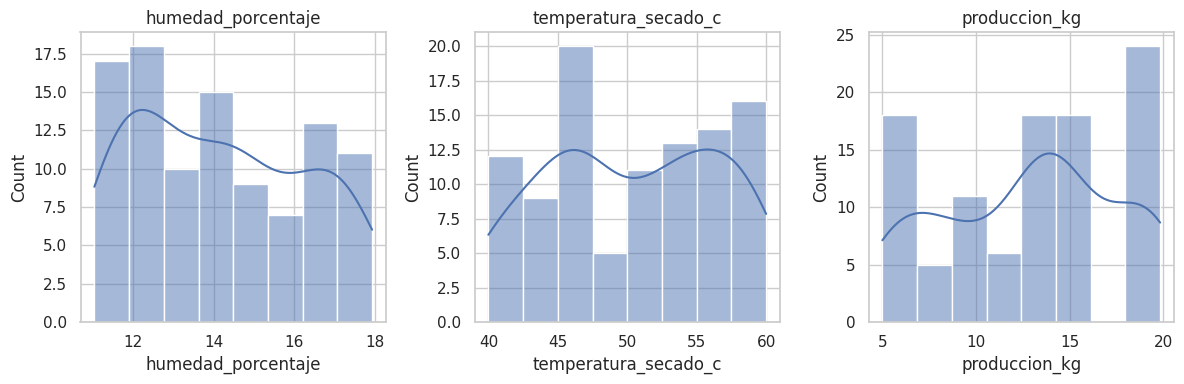

In [68]:
def panel_distribuciones(df):
    n = len(num_cols)

    cols = 3
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
    axes = axes.flatten()

    for ax, col in zip(axes, num_cols):
        sns.histplot(df[col], kde=True, ax=ax)
        ax.set_title(col)

    for ax in axes[n:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

panel_distribuciones(df)

Veamos si estas variables numéricas presentan alguna correlacion entre si mediante el uso del correlograma

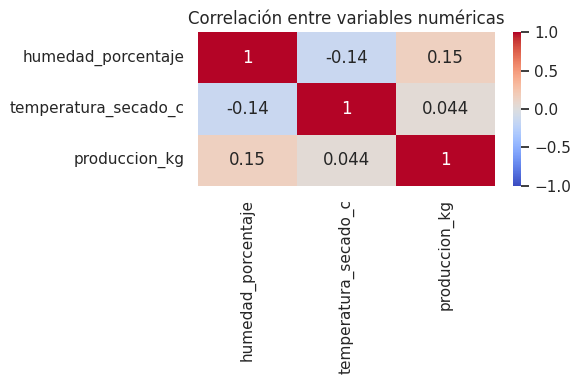

In [80]:
def correlograma_numericas(df):
    corr = df[num_cols].corr()

    plt.figure(figsize=(6, 4))
    sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlación entre variables numéricas")
    plt.tight_layout()
    plt.show()

correlograma_numericas(df)

Podemos observar que no existen correlaciones fuertes entre estas variables, sin embargo vemos correlaciones débiles:

 - entre el porcentaje de humedad y la temperatura de secado (negativa)
 - entre la producción y el porcentaje de humedad (positiva)

#### 2.- Distribución variables categóricas

Para complementar las distribuciones numéricas, reviso ahora las variables categóricas del
dataset. Este panel muestra la frecuencia de cada categoría mediante countplots, lo que
permite identificar desequilibrios entre lotes, productores, variedades o turnos.

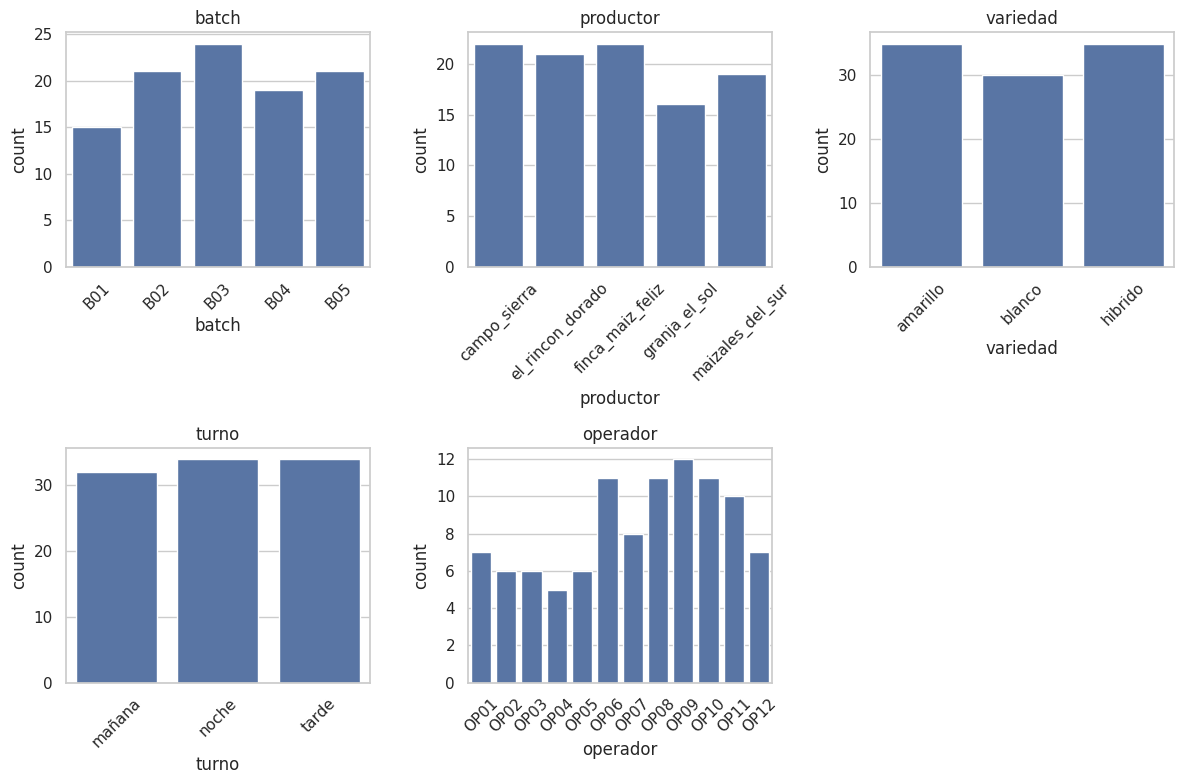

In [70]:
def panel_categoricas(df):
    n = len(cat_cols)

    cols = 3
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
    axes = axes.flatten()

    for ax, col in zip(axes, cat_cols):
        sns.countplot(x=df[col], ax=ax)
        ax.set_title(col)
        ax.tick_params(axis="x", rotation=45)

    for ax in axes[n:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

panel_categoricas(df)

#### 3.- Relaciones entre categóricas y numéricas mediante boxplots.

Para analizar cómo cambian las variables numéricas según los distintos grupos operativos
(batch, productor, variedad, turno, operador), genero un panel de boxplots que muestra
las diferencias de distribución entre categorías.

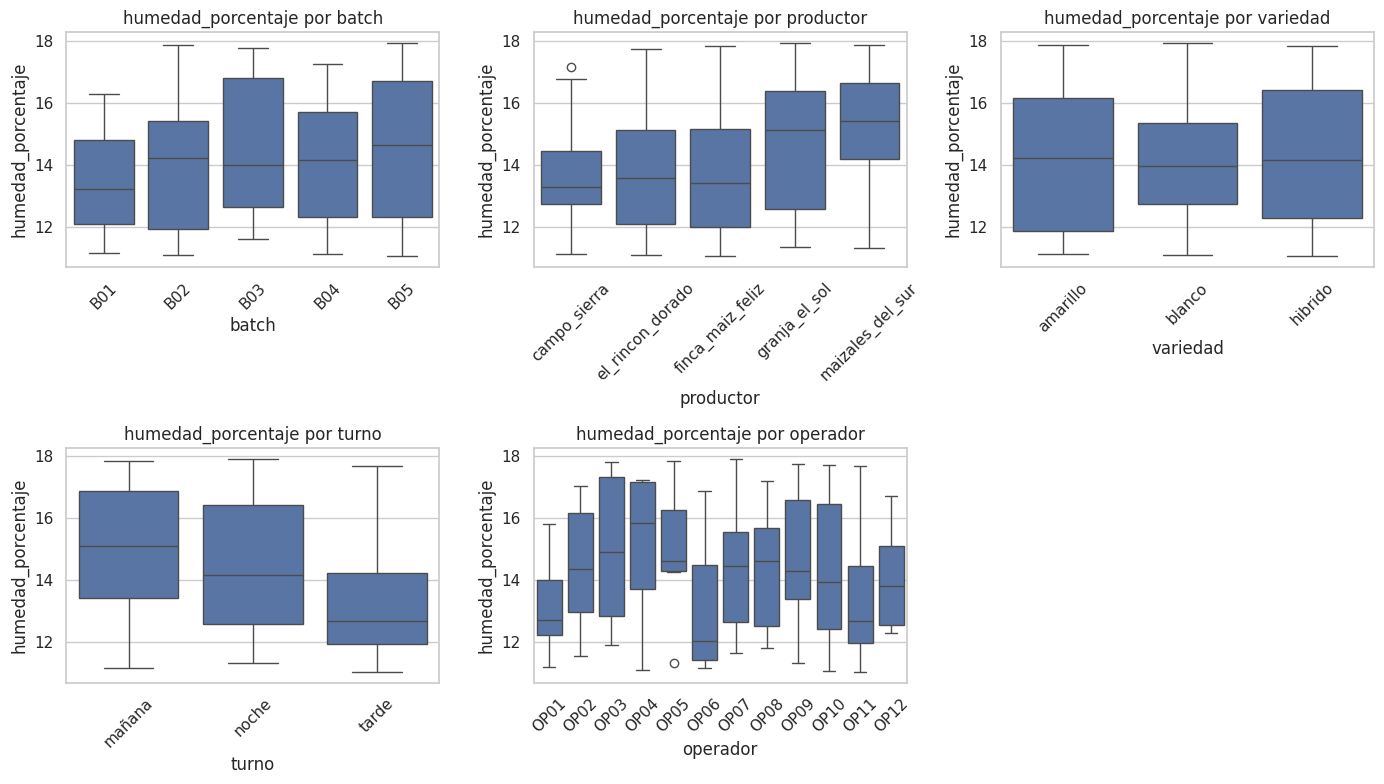

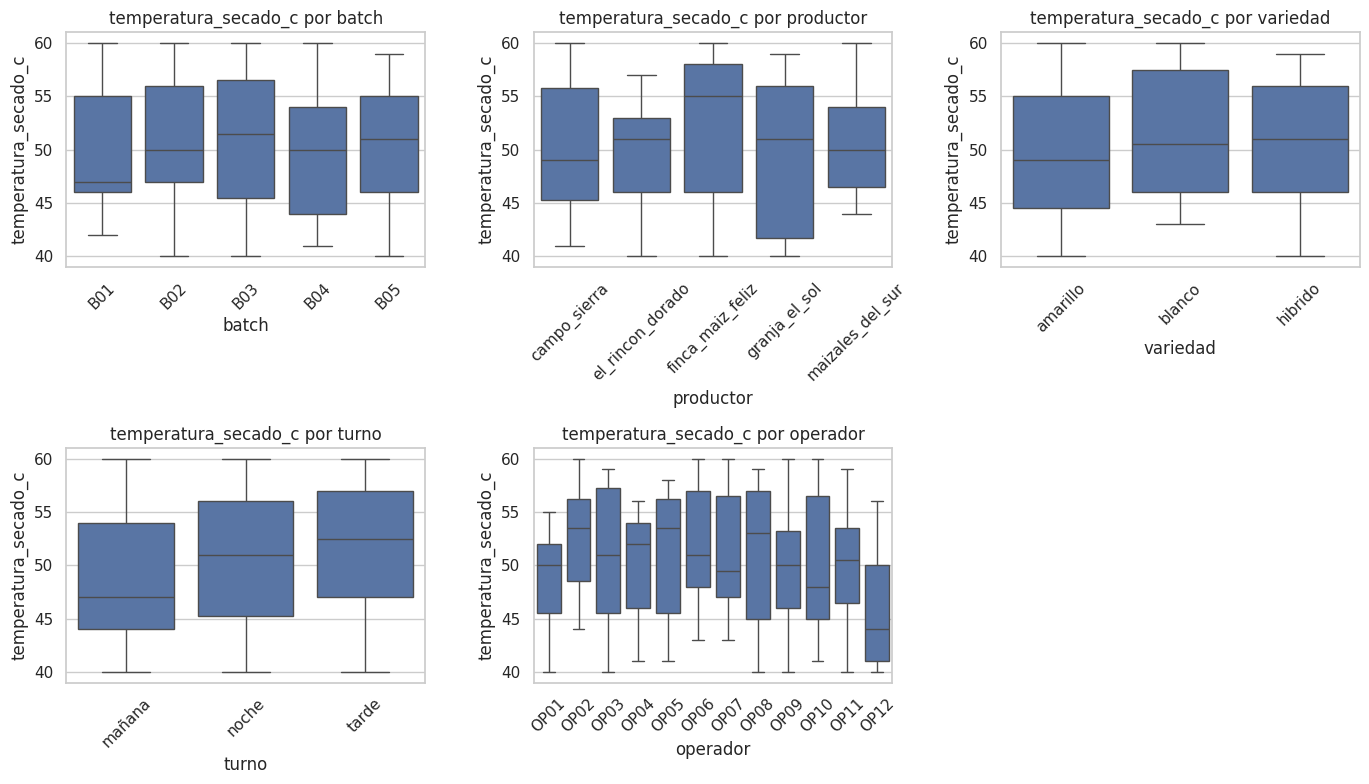

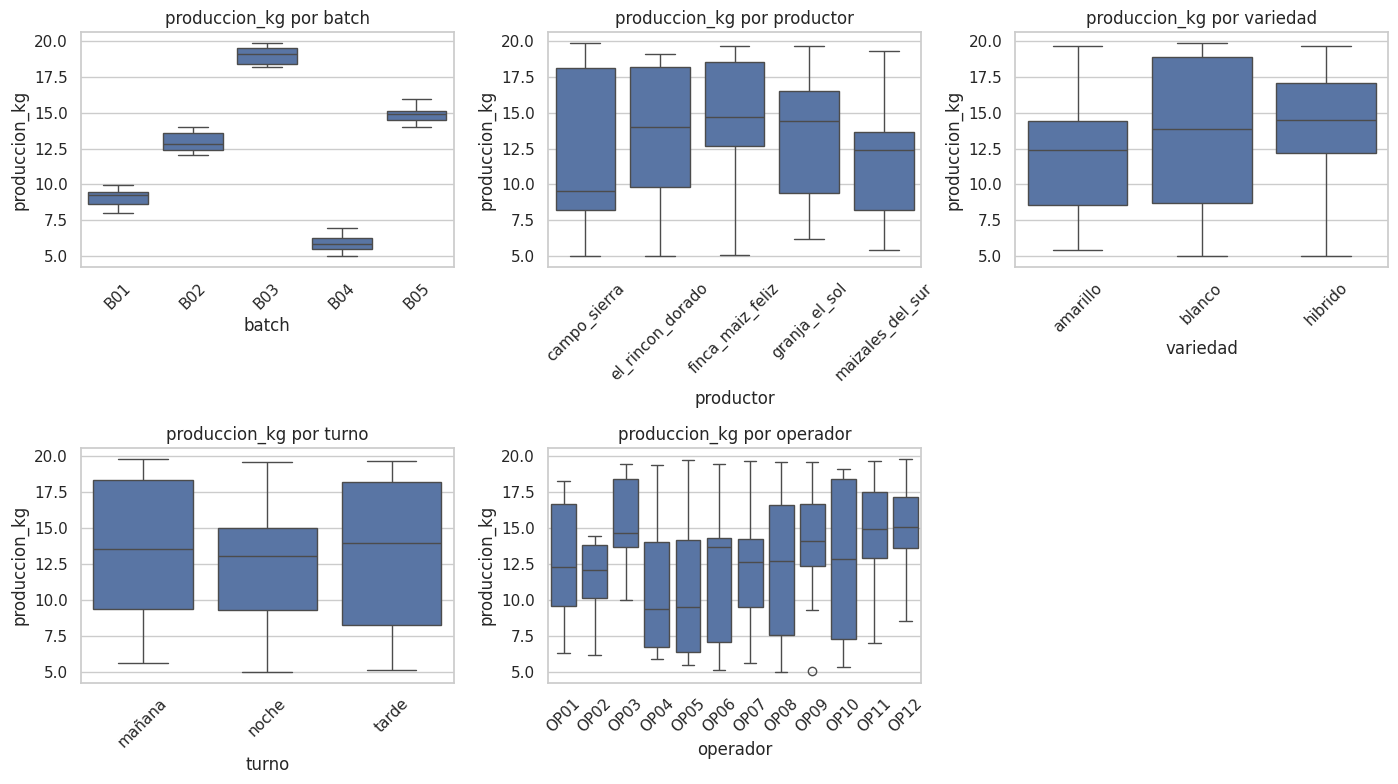

In [71]:
def panel_num_vs_cat(df):
    for num in num_cols:
        n = len(cat_cols)
        cols = 3
        rows = (n + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(14, 4*rows))
        axes = axes.flatten()

        for ax, cat in zip(axes, cat_cols):
            sns.boxplot(x=df[cat], y=df[num], ax=ax)
            ax.set_title(f"{num} por {cat}")
            ax.tick_params(axis='x', rotation=45)

        for ax in axes[n:]:
            ax.set_visible(False)

        plt.tight_layout()
        plt.show()

panel_num_vs_cat(df)

De estas últimas gráficas me llaman la atención 5 boxplots particulares las cuales creo que utilizando distribucion KDE podemos notar mas directamente ciertos patrones internos de la información

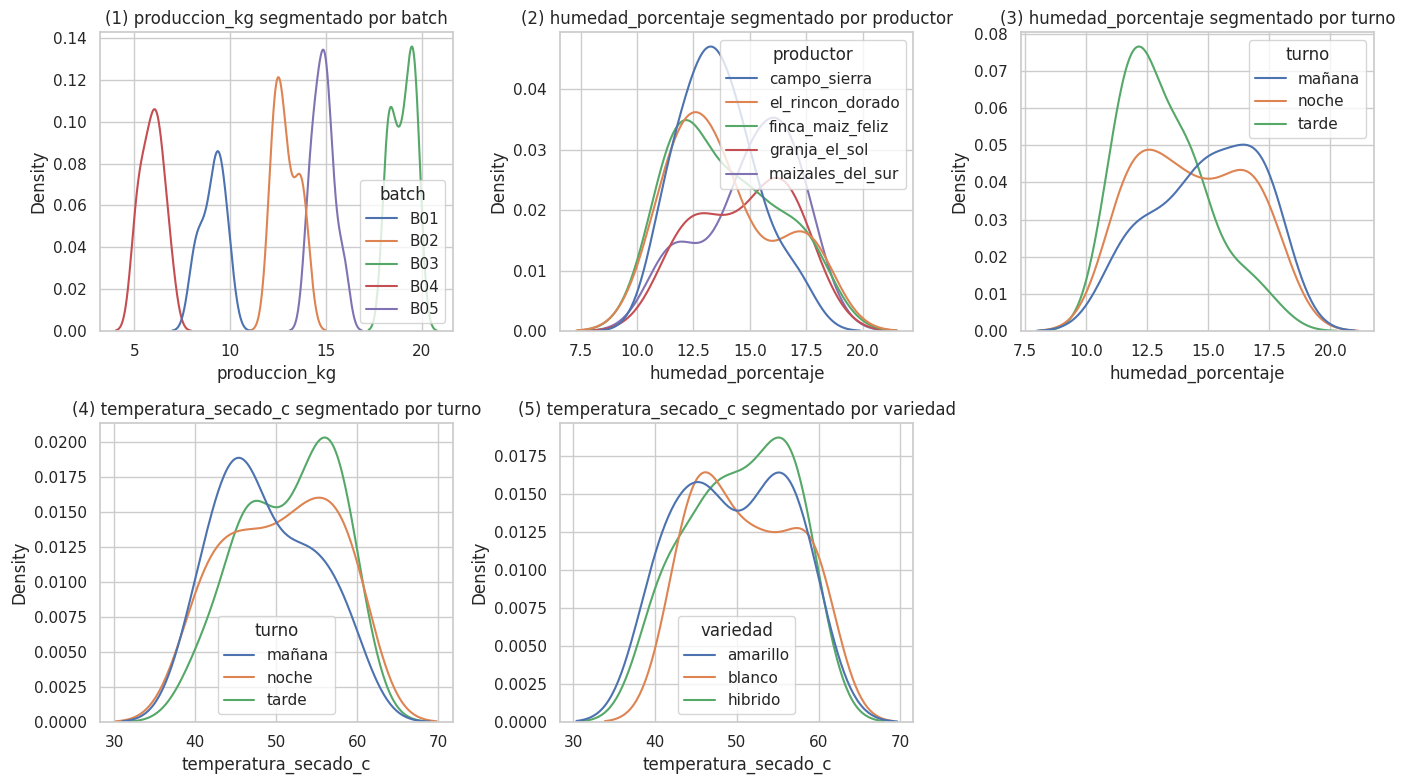

In [72]:
def distribuciones_segmentadas(df):
    specs = [
        ("produccion_kg", "batch", "(1)"),
        ("humedad_porcentaje", "productor", "(2)"),
        ("humedad_porcentaje", "turno", "(3)"),
        ("temperatura_secado_c", "turno", "(4)"),
        ("temperatura_secado_c", "variedad", "(5)"),
    ]

    n = len(specs)
    cols = 3
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(14, 4*rows))
    axes = axes.flatten()

    for ax, (num, cat, idx) in zip(axes, specs):
        sns.kdeplot(data=df, x=num, hue=cat, fill=False, ax=ax)
        ax.set_title(f"{idx} {num} segmentado por {cat.replace('_', ' ')}")
        ax.tick_params(axis="x", rotation=0)

    for ax in axes[n:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()


distribuciones_segmentadas(df)

1. Producción por batch (1)
   Los lotes muestran distribuciones bien separadas, indicando que cada batch opera en rangos
   de producción muy definidos y con poca variabilidad interna.

2. Humedad por productor (2)
   La humedad varía entre productores, lo que sugiere diferencias en prácticas de cosecha,
   manejo o condiciones iniciales del grano.

3. Humedad por turno (3)
   El turno de tarde tiende a registrar humedades más altas, mientras que mañana y noche son
   más consistentes. Esto apunta a cambios operativos o ambientales por horario.

4. Temperatura por turno (4)
   Cada turno trabaja naturalmente en rangos de temperatura distintos, con el turno de tarde ligeramente
   más alto.

5. Temperatura por variedad (5)
   Las variedades muestran patrones térmicos ligeramente distintos durante el secado,
   indicando ajustes operativos según el tipo de maíz.

En conjunto, estas segmentaciones muestran patrones claros dependientes de batch, turno,
productor y variedad que influyen en el comportamiento del grano.

